# Project I Guide
### DTSC 760
#### TA: Mohammed Hossain

## Part 0: Data Preprocessing
First, we need to load and preprocess the dataset.



In [33]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [34]:
import pandas as pd
import numpy as np
import requests
from io import StringIO
from scipy.spatial.distance import cityblock
import matplotlib.pyplot as plt
import seaborn as sns


file_path = "/content/drive/My Drive/Colab Notebooks/Biometrics/Project1/Data/DSL-StrongPasswordData.xls"
df = pd.read_excel(file_path)

WARNING *** OLE2 inconsistency: SSCS size is 0 but SSAT size is non-zero


In [35]:
def preprocess_data(df):
    columns = ['subject', 'sessionIndex', 'rep', 'H.period', 'DD.period.t', 'UD.period.t',
               'H.t', 'DD.t.i', 'UD.t.i', 'H.i', 'DD.i.e', 'UD.i.e',
               'H.e', 'DD.e.five', 'UD.e.five', 'H.five', 'DD.five.Shift.r', 'UD.five.Shift.r',
               'H.Shift.r', 'DD.Shift.r.o', 'UD.Shift.r.o', 'H.o', 'DD.o.a', 'UD.o.a',
               'H.a', 'DD.a.n', 'UD.a.n', 'H.n', 'DD.n.l', 'UD.n.l',
               'H.l', 'DD.l.Return', 'UD.l.Return', 'H.Return']

    processed_df = df[columns]
    return processed_df

processed_df = preprocess_data(df)

## Part 1: Template Creation

Preprocess the Data: Select relevant columns for the analysis, excluding unnecessary ones like 'subject', 'sessionIndex', and 'rep'.

1. Compute the Template: Calculate the mean keystroke timings for each subject using the first
N samples.

In [36]:
# Compute the Template
def compute_template(processed_df, N):
    templates = {}
    for subject in processed_df['subject'].unique():
        subject_data = processed_df[processed_df['subject'] == subject].iloc[:N, 3:]  # Exclude 'subject', 'sessionIndex', 'rep'
        templates[subject] = subject_data.mean().values
    return templates

2. Compute Genuine & Imposter Scores: Calculate the Manhattan distance (cityblock) between the template and each subsequent keystroke sample of the same subject.

In [37]:
# Compute Genuine and Impostor Scores
def compute_scores(processed_df, templates, N):
    genuine_scores = []
    impostor_scores = []

    for subject in processed_df['subject'].unique():
        template = templates[subject]
        subject_data = processed_df[processed_df['subject'] == subject].iloc[N:, 3:]

        for _, row in subject_data.iterrows():
            score = cityblock(template, row.values)
            genuine_scores.append(score)

        # Sample one impostor attempt per other subject
        impostor_subjects = processed_df['subject'].unique()
        impostor_subjects = impostor_subjects[impostor_subjects != subject]  # Exclude current subject

        for impostor_subject in impostor_subjects:
            impostor_data = processed_df[processed_df['subject'] == impostor_subject].iloc[:, 3:]
            impostor_sample = impostor_data.sample(n=1, random_state=42)
            for _, row in impostor_sample.iterrows():
                score = cityblock(template, row.values)
                impostor_scores.append(score)

    return genuine_scores, impostor_scores

1. Genuine Scores:


*   For each subject, the template (mean keystroke timing vector) is compared to the subject's subsequent typing samples (excluding the first N used for the template) using the Manhattan distance.

*   The computed distances (scores) between each typing sample and the template are stored in the genuine_scores list.


\


2. Impostor Scores:


*   For each subject, a single random typing sample from each of the other subjects is compared to the subject's template using the Manhattan distance.

*   The distances (scores) are stored in the impostor_scores list, and these scores are expected to be typically lower than the genuine scores due to the dissimilarity between the impostor samples and the subject's template, ensuring genuine attempts are easier to distinguish.


## Part 2: Display FAR and FRR for N = 200

Calculate FAR and FRR: For each threshold, calculate the False Accept Rate (FAR) and False Reject Rate (FRR) based on the scores.

In [38]:
# Compute Scores for N = 200
N = 200
templates = compute_template(processed_df, N)
genuine_scores, impostor_scores = compute_scores(processed_df, templates, N)

# Calculate FAR and FRR for specific thresholds
def calculate_far_frr(genuine_scores, impostor_scores, thresholds):
    results = []
    for threshold in thresholds:
        false_accepts = sum(1 for score in impostor_scores if score < threshold)
        false_rejects = sum(1 for score in genuine_scores if score >= threshold)

        far = false_accepts / len(impostor_scores)
        frr = false_rejects / len(genuine_scores)

        results.append((threshold, far, frr))

    return results

Print Results: Print the FAR, FRR, total genuine attempts, total impostor attempts, total false accepts, and total false rejects for each threshold when N=200.

In [39]:
thresholds = [0.5, 1.0, 3.2, 7.1, 10.7]
far_frr_results = calculate_far_frr(genuine_scores, impostor_scores, thresholds)

print(f"For N = {N}")
for threshold, far, frr in far_frr_results:
    print(f"Threshold: {threshold}")
    print(f"FAR: {far}, FRR: {frr}")
    print(f"Total Genuine Attempts: {len(genuine_scores)}")
    print(f"Total Imposter Attempts: {len(impostor_scores)}")
    print(f"Total False Accepts: {far * len(impostor_scores)}")
    print(f"Total False Rejects: {frr * len(genuine_scores)}")
    print()

For N = 200
Threshold: 0.5
FAR: 0.0, FRR: 0.9992156862745099
Total Genuine Attempts: 10200
Total Imposter Attempts: 2550
Total False Accepts: 0.0
Total False Rejects: 10192.0

Threshold: 1.0
FAR: 0.019215686274509803, FRR: 0.8719607843137255
Total Genuine Attempts: 10200
Total Imposter Attempts: 2550
Total False Accepts: 49.0
Total False Rejects: 8894.0

Threshold: 3.2
FAR: 0.6592156862745098, FRR: 0.09490196078431372
Total Genuine Attempts: 10200
Total Imposter Attempts: 2550
Total False Accepts: 1681.0
Total False Rejects: 967.9999999999999

Threshold: 7.1
FAR: 0.9098039215686274, FRR: 0.006274509803921568
Total Genuine Attempts: 10200
Total Imposter Attempts: 2550
Total False Accepts: 2320.0
Total False Rejects: 64.0

Threshold: 10.7
FAR: 0.9996078431372549, FRR: 0.0004901960784313725
Total Genuine Attempts: 10200
Total Imposter Attempts: 2550
Total False Accepts: 2549.0
Total False Rejects: 5.0



## Part 3: FAR at 0 FRR

Find FAR at Zero FRR: Determine the threshold where FRR is zero and calculate the FAR at that threshold for each N value.

In [40]:
# Calculate FAR at 0 FRR for each N
def find_far_at_zero_frr(genuine_scores, impostor_scores):
    max_genuine_score = max(genuine_scores)
    threshold = max_genuine_score + 1  # Ensures zero FRR
    false_accepts = sum(1 for score in impostor_scores if score < threshold)
    far = false_accepts / len(impostor_scores)
    return threshold, far



Print Results: Print the threshold where FRR is zero and the corresponding FAR for each N value

In [41]:
Ns = [100, 200, 300]
analysis = {}
for N in Ns:
    templates = compute_template(processed_df, N)
    genuine_scores, impostor_scores = compute_scores(processed_df, templates, N)

    analysis[N] = {
        'genuine_scores': genuine_scores,
        'impostor_scores': impostor_scores
    }

    threshold, far = find_far_at_zero_frr(genuine_scores, impostor_scores)
    print(f"N = {N}")
    print(f"Threshold where FRR is zero: {threshold}")
    print(f"FAR at 0 FRR: {far}")
    print()

N = 100
Threshold where FRR is zero: 28.848426000000003
FAR at 0 FRR: 1.0

N = 200
Threshold where FRR is zero: 16.114137999999997
FAR at 0 FRR: 1.0

N = 300
Threshold where FRR is zero: 15.516614000000002
FAR at 0 FRR: 1.0



## Plot Distributions

Combined Plot: Create a combined plot with genuine score distributions on the left and impostor score distributions on the right for all N values.

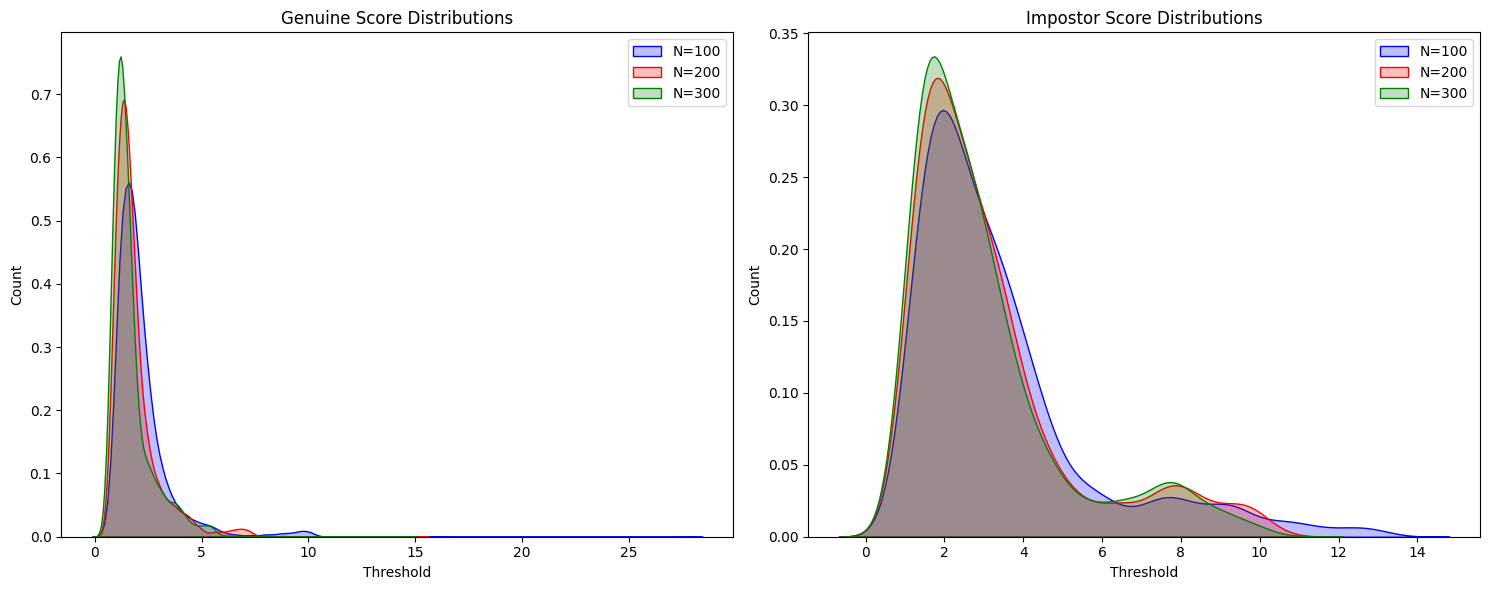

In [42]:
# Combined Plot for All N Values
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6))


# Plot Genuine Scores
genuine_colors = ['blue', 'red', 'green']
for i, N in enumerate(Ns):
    sns.kdeplot(analysis[N]['genuine_scores'], fill=True, color=genuine_colors[i], ax=axes[0], label=f'N={N}')
axes[0].set_xlabel('Threshold')
axes[0].set_ylabel('Count')
axes[0].set_title('Genuine Score Distributions')
axes[0].legend()

# Plot Impostor Scores
impostor_colors = ['blue', 'red', 'green']
for i, N in enumerate(Ns):
    sns.kdeplot(analysis[N]['impostor_scores'], fill=True, color=impostor_colors[i], ax=axes[1], label=f'N={N}')
axes[1].set_xlabel('Threshold')
axes[1].set_ylabel('Count')
axes[1].set_title('Impostor Score Distributions')
axes[1].legend()

plt.tight_layout()
plt.show()


Individual Plots: Plot the score distributions for genuine and impostor attempts for each N value.



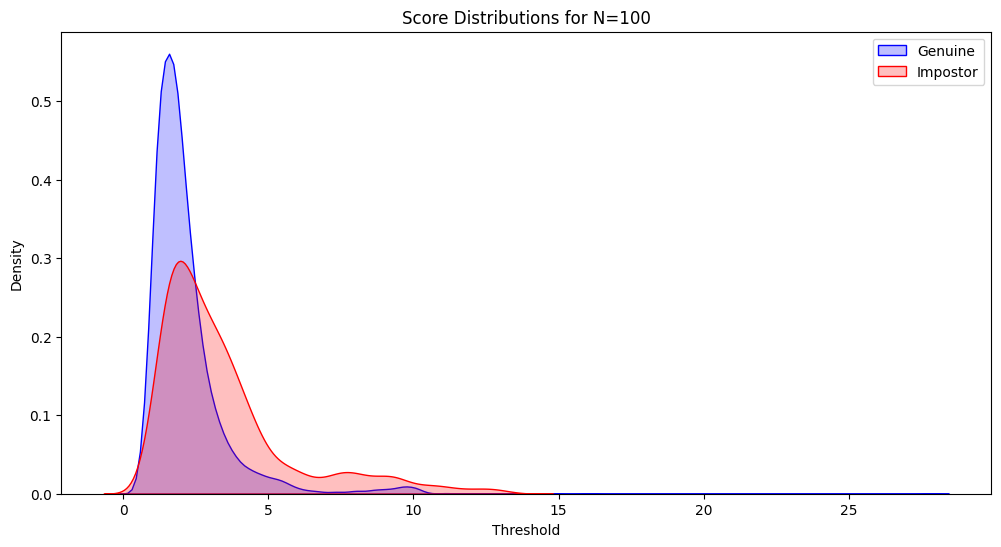

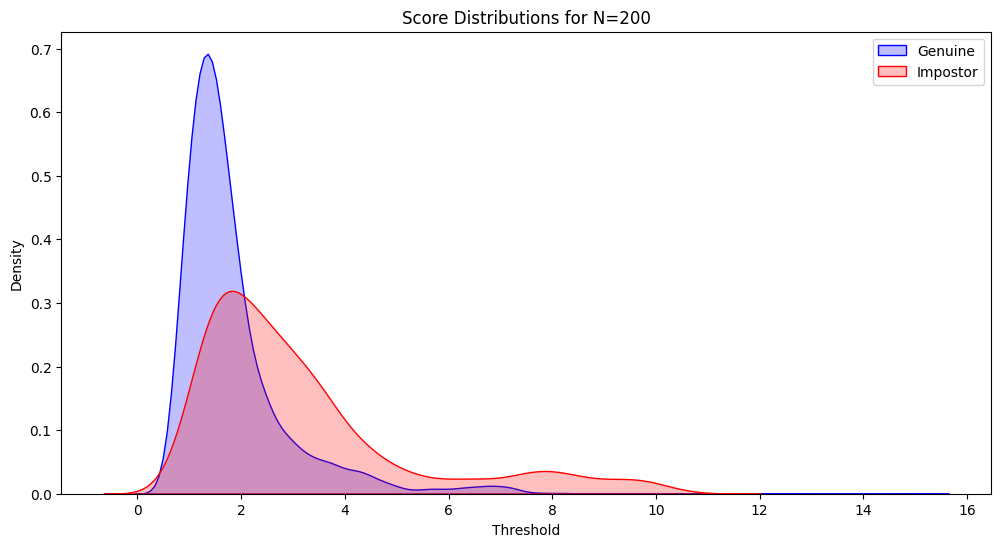

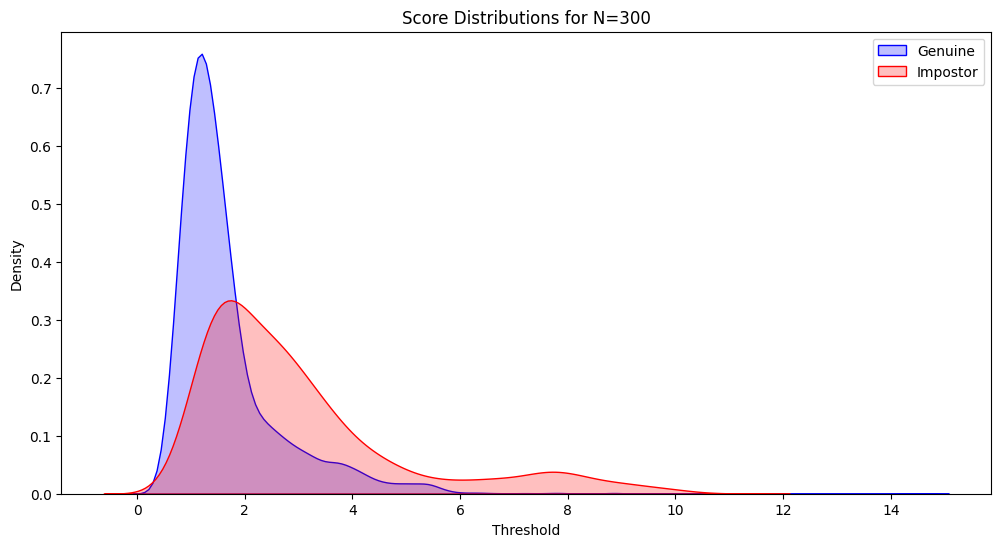

In [43]:
# Plot Genuine vs. Impostor Distributions for Each N Value
for N in Ns:
    plt.figure(figsize=(12, 6))
    sns.kdeplot(analysis[N]['genuine_scores'], fill=True, color='blue', label='Genuine')
    sns.kdeplot(analysis[N]['impostor_scores'], fill=True, color='red', label='Impostor')
    plt.title(f'Score Distributions for N={N}')
    plt.xlabel('Threshold')
    plt.ylabel('Density')
    plt.legend()
    plt.show()



The seaborn.kdeplot function by default normalizes the area under the KDE (Kernel Density Estimate) curve to 1. This normalization causes the y-axis to display decimal values representing density rather than actual counts. To visualize the genuine and impostor score distributions with actual counts on the y-axis, we need to adjust the KDE plots to scale the densities by the number of samples. This can be achieved by using the weights parameter to scale the densities appropriately, allowing the y-axis to reflect the true counts.